In [ ]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes
!pip install geocoder
!pip install beautifulsoup4
!pip install urlopen
!pip install --upgrade numpy

In [ ]:
!pip install -U numpy
!pip install -U pandas
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 
import folium 
from bs4 import BeautifulSoup
import csv
import geocoder 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
import csv
from urllib.request import urlopen
import os

In [1]:
from sklearn.cluster import KMeans

In [4]:
html = urlopen("https://en.wikipedia.org/wiki/Special_wards_of_Tokyo")
html_parser = BeautifulSoup(html, "html.parser")

In [5]:
os.chdir('/tmp')
path = 'tokyo.csv'
csv_file = open(path, 'w')
csv_writer = csv.writer(csv_file)

In [6]:
table = html_parser.findAll("table", {"class":"wikitable sortable"})[0]
rows = table.findAll("tr")

with open("tokyo.csv", "w", encoding='utf-8') as file:
    writer = csv.writer(file)
    for row in rows:
        csvRow = []
        for cell in row.findAll(['td', 'th']):
            csvRow.append(cell.get_text())
        writer.writerow(csvRow)

In [7]:
csv_file.close()

In [8]:
tokyo_data = pd.read_csv('tokyo.csv')

In [9]:
tokyo_data.shape

(24, 8)

In [10]:
tokyo_data = tokyo_data[["Name\n"]]

In [26]:
tokyo_ward = tokyo_data.drop(23)
tokyo_ward = tokyo_ward.rename(columns={'Name\n': 'Neighbourhood'})
tokyo_ward

,Neighbourhood
0,Chiyoda
1,Chūō
2,Minato
3,Shinjuku
4,Bunkyō
5,Taitō
6,Sumida
7,Kōtō
8,Shinagawa
9,Meguro


In [28]:
lat = []
lng = []
lat_lng_coords = None

neighbourhoods = tokyo_ward['Neighbourhood']

for nh in neighbourhoods:
    g = geocoder.arcgis('{}, Tokyo, JP'.format(nh))
    lat_lng_coords = g.latlng
    lat.append(lat_lng_coords[0])
    lng.append(lat_lng_coords[1])

In [31]:
tokyo_geo =  tokyo_ward
tokyo_geo['Latitude'] = lat
tokyo_geo['Longitude'] = lng

In [32]:
tokyo_geo.head()

,Neighbourhood,Latitude,Longitude
0,Chiyoda,35.693930,139.753711
1,Chūō,35.670572,139.771988
2,Minato,35.658017,139.751546
3,Shinjuku,35.693798,139.703440
4,Bunkyō,35.707595,139.752210


In [33]:
CLIENT_ID = '5IPRQVLM2TWU4BSGCUIXQF1W35EYULBNCNZC0AXHRDTI5MTQ'
CLIENT_SECRET = 'W2RQZ4JYWFLJQ2RCSMFGHUZQRABNPWEX43LD3VIKSXKWAYD1'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5IPRQVLM2TWU4BSGCUIXQF1W35EYULBNCNZC0AXHRDTI5MTQ
CLIENT_SECRET:W2RQZ4JYWFLJQ2RCSMFGHUZQRABNPWEX43LD3VIKSXKWAYD1


In [35]:
from geopy.geocoders import Nominatim

address = 'Tokyo, JP'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tokyo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tokyo are 35.6828387, 139.7594549.


In [38]:
tokyo_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(tokyo_geo['Latitude'], tokyo_geo['Longitude'], tokyo_geo['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tokyo_map)  
    
tokyo_map

In [39]:
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
explore_df_list = []
for i, nhood_name in enumerate(tokyo_geo['Neighbourhood']):  
    try :
        nhood_name = tokyo_geo.loc[i, 'Neighbourhood']
        nhood_lat = tokyo_geo.loc[i, 'Latitude']
        nhood_lng = tokyo_geo.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nhood_lat, nhood_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results)
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist() 
            f_list = [nhood_name, nhood_lat, nhood_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [42]:
explore_tokyo = pd.DataFrame([item for item in explore_df_list])
explore_tokyo.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_tokyo.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,Chiyoda,35.69393,139.753711,Kanda Tendonya (神田天丼家),Tempura Restaurant,35.695765,139.754682
1,Chiyoda,35.69393,139.753711,Bondy (欧風カレー ボンディ),Japanese Curry Restaurant,35.695544,139.757356
2,Chiyoda,35.69393,139.753711,Jimbocho Kurosu (神保町 黒須),Ramen Restaurant,35.695539,139.754851
3,Chiyoda,35.69393,139.753711,National Museum of Modern Art (東京国立近代美術館),Art Museum,35.690541,139.754694
4,Chiyoda,35.69393,139.753711,Kitanomaru Park (北の丸公園),Park,35.691653,139.751201


In [44]:
tokyo_1hot = pd.get_dummies(explore_tokyo[['Venue Category']], prefix="", prefix_sep="")
tokyo_1hot['Neighbourhood'] = explore_tokyo['Neighbourhood'] 
fixed_columns = [tokyo_1hot.columns[-1]] + tokyo_1hot.columns[:-1].values.tolist()
tokyo_1hot = tokyo_1hot[fixed_columns]
tokyo_1hot.head()

,Neighbourhood,African Restaurant,American Restaurant,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boarding House,Bookstore,Brazilian Restaurant,Brewery,Buddhist Temple,Buffet,Burger Joint,Butcher,Café,Camera Store,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Shop,Donburi Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,German Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Heliport,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Imported Food Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Family Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kaiseki Restaurant,Kushikatsu Restaurant,Liquor Store,Lounge,Martial Arts School,Mexican Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nabe Restaurant,Noodle House,Paper / Office Supplies Store,Park,Pastry Shop,Pizza Place,Port,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Roller Rink,Russian Restaurant,Sake Bar,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Soba Restaurant,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Stadium,Stationery Store,Steakhouse,Sukiyaki Restaurant,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Teishoku Restaurant,Tempura Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tonkatsu Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wagashi Place,Wine Bar,Wine Shop,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,Chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chiyoda,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chiyoda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
tokyo_grouped = tokyo_1hot.groupby('Neighbourhood').mean().reset_index()
tokyo_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Stadium,Bath House,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Boarding House,Bookstore,Brazilian Restaurant,Brewery,Buddhist Temple,Buffet,Burger Joint,Butcher,Café,Camera Store,Candy Store,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cultural Center,Cupcake Shop,Deli / Bodega,Dessert Shop,Discount Store,Dive Shop,Donburi Restaurant,Drugstore,Dumpling Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Fast Food Restaurant,Fish Market,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,German Restaurant,Grocery Store,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Heliport,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Imported Food Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Family Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kaiseki Restaurant,Kushikatsu Restaurant,Liquor Store,Lounge,Martial Arts School,Mexican Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nabe Restaurant,Noodle House,Paper / Office Supplies Store,Park,Pastry Shop,Pizza Place,Port,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Club,Roller Rink,Russian Restaurant,Sake Bar,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Soba Restaurant,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Stadium,Stationery Store,Steakhouse,Sukiyaki Restaurant,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Takoyaki Place,Tea Room,Teishoku Restaurant,Tempura Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tonkatsu Restaurant,Tourist Information Center,Toy / Game Store,Trail,Train Station,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wagashi Place,Wine Bar,Wine Shop,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,Adachi,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.233333,0.0,0.0,0.000000,0.0,0.100000,0.0,0.033333,0.066667,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.000000,0.000000,0.033333,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.033333,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.033333,0.033333,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Arakawa,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.033333,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.033333,0.0,0.0,0.033333,0.0,0.033333,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.066667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.033333,0.000000,0.0,0.066667,0.0,0.000000,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.133333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.033333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.033333,

In [48]:
def top_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

In [49]:
top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = tokyo_grouped['Neighbourhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = top_common_venues(tokyo_grouped.iloc[ind, :], top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adachi,Convenience Store,Supermarket,Discount Store,Drugstore,BBQ Joint,Noodle House,Ramen Restaurant,Furniture / Home Store,Pizza Place,Pastry Shop
1,Arakawa,Ramen Restaurant,BBQ Joint,Grocery Store,Supermarket,Park,Japanese Restaurant,Shopping Mall,Café,Burger Joint,Discount Store
2,Bunkyō,Hotel,Baseball Stadium,Japanese Restaurant,Garden,Theme Park,Theater,Chinese Restaurant,Steakhouse,Stadium,Seafood Restaurant
3,Chiyoda,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,BBQ Joint,Sushi Restaurant,Gastropub,Historic Site,Coffee Shop,Comedy Club
4,Chūō,Ramen Restaurant,Sushi Restaurant,Yoshoku Restaurant,Coffee Shop,Soba Restaurant,Italian Restaurant,Tonkatsu Restaurant,Steakhouse,Chinese Restaurant,Deli / Bodega


In [50]:
tokyo_grouped_clustering = tokyo_grouped.drop('Neighbourhood', 1)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [53]:
max_range = 15

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for tokyo_clusters in range(2, max_range) :
    
    tokyo_gc = tokyo_grouped_clustering
    kmeans = KMeans(n_clusters = tokyo_clusters, init = 'k-means++', random_state = 0).fit_predict(tokyo_gc)
    
    score = silhouette_score(tokyo_gc, kmeans)

    indices.append(tokyo_clusters)
    scores.append(score)

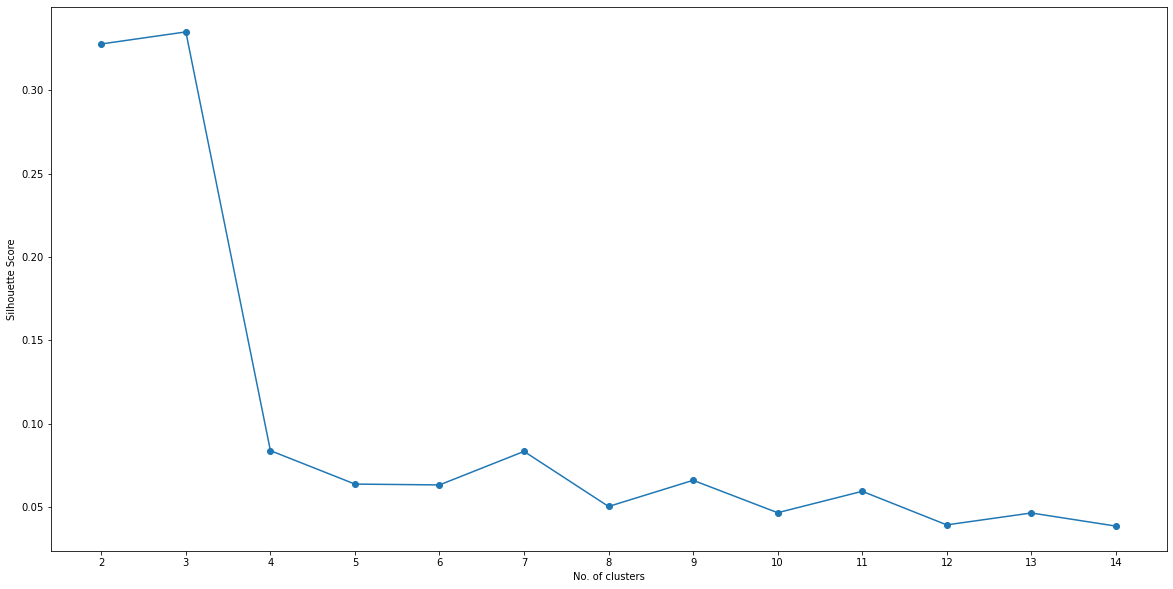

In [54]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [55]:
opt_value = 8

In [56]:
tokyo_clusters = opt_value

tokyo_gc = tokyo_grouped_clustering
kmeans = KMeans(n_clusters = tokyo_clusters, init = 'k-means++', random_state = 0).fit(tokyo_gc)

In [57]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [59]:
tokyo_final = tokyo_geo
tokyo_final = tokyo_final.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
tokyo_final.dropna(inplace = True)
tokyo_final['Cluster Labels'] = tokyo_final['Cluster Labels'].astype(int)
tokyo_final.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,35.693930,139.753711,7,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,BBQ Joint,Sushi Restaurant,Gastropub,Historic Site,Coffee Shop,Comedy Club
1,Chūō,35.670572,139.771988,3,Ramen Restaurant,Sushi Restaurant,Yoshoku Restaurant,Coffee Shop,Soba Restaurant,Italian Restaurant,Tonkatsu Restaurant,Steakhouse,Chinese Restaurant,Deli / Bodega
2,Minato,35.658017,139.751546,2,Japanese Restaurant,Historic Site,Ramen Restaurant,BBQ Joint,Chinese Restaurant,Tonkatsu Restaurant,Buddhist Temple,Monument / Landmark,Park,Pizza Place
3,Shinjuku,35.693798,139.703440,3,Bar,Sake Bar,Yakitori Restaurant,Thai Restaurant,Spa,Clothing Store,Pub,Chinese Restaurant,Hookah Bar,Food & Drink Shop
4,Bunkyō,35.707595,139.752210,3,Hotel,Baseball Stadium,Japanese Restaurant,Garden,Theme Park,Theater,Chinese Restaurant,Steakhouse,Stadium,Seafood Restaurant


In [60]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(tokyo_clusters)
ys = [i + x + (i*x)**2 for i in range(tokyo_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_final['Latitude'], tokyo_final['Longitude'], tokyo_final['Neighbourhood'], 
                                  tokyo_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

In [61]:
val = 1
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Adachi,Convenience Store,Supermarket,Discount Store,Drugstore,BBQ Joint,Noodle House,Ramen Restaurant,Furniture / Home Store,Pizza Place,Pastry Shop


In [62]:
val = 2
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Taitō,Sake Bar,Ramen Restaurant,Cocktail Bar,Soba Restaurant,Science Museum,Sauna / Steam Room,Chinese Restaurant,Halal Restaurant,Café,Supermarket
8,Shinagawa,Sake Bar,Ramen Restaurant,Theater,Steakhouse,Coffee Shop,Park,French Restaurant,Donburi Restaurant,Gastropub,Restaurant
14,Suginami,Sake Bar,Ramen Restaurant,BBQ Joint,Wagashi Place,Italian Restaurant,Café,Japanese Restaurant,Thai Restaurant,Event Space,Soba Restaurant
18,Itabashi,Ramen Restaurant,Sake Bar,Yoshoku Restaurant,Steakhouse,Café,Japanese Restaurant,Burger Joint,Udon Restaurant,Thai Restaurant,Sushi Restaurant
19,Nerima,Ramen Restaurant,Sake Bar,Soba Restaurant,BBQ Joint,Grocery Store,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Stadium,Garden Center
21,Katsushika,Sake Bar,Discount Store,Concert Hall,Sushi Restaurant,Takoyaki Place,Italian Restaurant,Drugstore,Train Station,Dumpling Restaurant,Donburi Restaurant


In [63]:
val = 3
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Minato,Japanese Restaurant,Historic Site,Ramen Restaurant,BBQ Joint,Chinese Restaurant,Tonkatsu Restaurant,Buddhist Temple,Monument / Landmark,Park,Pizza Place
7,Kōtō,Ramen Restaurant,French Restaurant,Steakhouse,BBQ Joint,Convenience Store,Park,Japanese Restaurant,Hotel,Factory,Discount Store
11,Setagaya,Ramen Restaurant,Japanese Restaurant,Soba Restaurant,Café,Sake Bar,Takoyaki Place,Candy Store,Chinese Restaurant,Pizza Place,Supermarket
16,Kita,Ramen Restaurant,Café,Park,Garden,Sake Bar,Drugstore,Fried Chicken Joint,Convenience Store,Grocery Store,Rock Club
17,Arakawa,Ramen Restaurant,BBQ Joint,Grocery Store,Supermarket,Park,Japanese Restaurant,Shopping Mall,Café,Burger Joint,Discount Store


In [64]:
val = 4
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chūō,Ramen Restaurant,Sushi Restaurant,Yoshoku Restaurant,Coffee Shop,Soba Restaurant,Italian Restaurant,Tonkatsu Restaurant,Steakhouse,Chinese Restaurant,Deli / Bodega
3,Shinjuku,Bar,Sake Bar,Yakitori Restaurant,Thai Restaurant,Spa,Clothing Store,Pub,Chinese Restaurant,Hookah Bar,Food & Drink Shop
4,Bunkyō,Hotel,Baseball Stadium,Japanese Restaurant,Garden,Theme Park,Theater,Chinese Restaurant,Steakhouse,Stadium,Seafood Restaurant
6,Sumida,Japanese Restaurant,Dessert Shop,Ramen Restaurant,Soba Restaurant,Café,Bakery,Wagashi Place,Sukiyaki Restaurant,Hobby Shop,Thai Restaurant
9,Meguro,BBQ Joint,Coffee Shop,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Yakitori Restaurant,Yoga Studio,Udon Restaurant,Yoshoku Restaurant,Sushi Restaurant
13,Nakano,BBQ Joint,Japanese Restaurant,Bookstore,Seafood Restaurant,Yakitori Restaurant,Ramen Restaurant,Sushi Restaurant,Sake Bar,Concert Hall,Hookah Bar


In [65]:
val = 5
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,OtaŌta,Hotel,Hotel Bar,Chinese Restaurant,Scenic Lookout,Italian Restaurant,Café,Cocktail Bar,Salad Place,Teishoku Restaurant,Buffet


In [66]:
val = 6
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Edogawa,Convenience Store,Grocery Store,Donburi Restaurant,Dumpling Restaurant,Furniture / Home Store,Clothing Store,Ramen Restaurant,Pizza Place,Cultural Center,Unagi Restaurant


In [67]:
val = 7
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Toshima,Harbor / Marina,Supermarket,Heliport,History Museum,Boarding House,Port,Dive Shop,Science Museum,Shabu-Shabu Restaurant,Ramen Restaurant


In [68]:
val = 8
tokyo_final.loc[tokyo_final['Cluster Labels'] == (val - 1), tokyo_final.columns[[0] + np.arange(4, tokyo_final.shape[1]).tolist()]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,Café,Ramen Restaurant,Japanese Curry Restaurant,Chinese Restaurant,BBQ Joint,Sushi Restaurant,Gastropub,Historic Site,Coffee Shop,Comedy Club
12,Shibuya,Café,Bookstore,Record Shop,Concert Hall,Tea Room,Toy / Game Store,Chinese Restaurant,Cocktail Bar,Comedy Club,African Restaurant
